## Quantum State Tomography (QST)


QST reconstrcut the $n$-qubit density matrix $\rho$ as,
$$
\rho=\frac{1}{2^n} \sum_{i, j,\ldots \ell=0}^3 c_{i j \ldots \ell} \sigma_i^{(1)} \otimes \sigma_j^{(2)} \ldots \otimes \sigma_\ell^{(n)},
$$
where $c_{i j \ldots \ell} \in \mathbb{C}$ and each $\sigma \in \{\sigma_x, \sigma_y, \sigma_z\}$.
Here, we demonstrate how to briefly use `qiskit-experiments` package to implement QST with  and without measurement error mitigation.
For more details about API and the package itself, please refer to [here](https://qiskit-community.github.io/qiskit-experiments/manuals/verification/state_tomography.html).

### Setup the backend

In [1]:
%%capture
from qiskit_ibm_runtime import QiskitRuntimeService

# Get a real backend from the runtime service
service = QiskitRuntimeService()

device = service.backend('ibm_fez')

If you don't have access to the hardware, please use the following fake backend that mimics the real hardware with past calibration data.

In [2]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeFez

noiseless_backend = AerSimulator()  # if don't want hardware noise
backend = AerSimulator.from_backend(FakeFez())

### Circuit construction

In this tutorial, we will use the `RealAmplitudes` ansatz that consists of layers of $R_y$ rotation gates and adjacent CNOT gates.

In [3]:
import dill as pickle

# Load pre-generated parameters
with open('params.pkl', 'rb') as f:
    loaded_param = pickle.load(f)

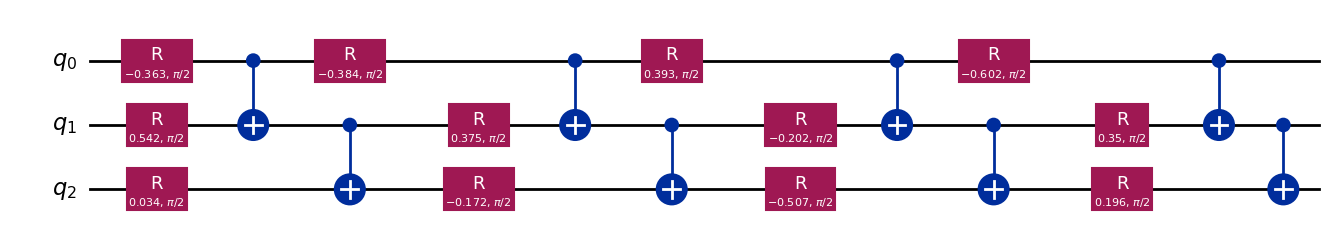

In [4]:
from qiskit.circuit.library import real_amplitudes

num_qubits = 3
num_layers = 4
ansatz = real_amplitudes(num_qubits, entanglement='pairwise', reps=num_layers, skip_final_rotation_layer=True)
params = loaded_param['parameter'][(num_qubits, num_layers)][0]  # contains 5 groups of parameters
ansatz.assign_parameters(params, inplace=True)
ansatz.decompose().draw("mpl")

### QST without error mitigation

In [5]:
from qiskit_experiments.library import StateTomography

# Set number of experiment shots
shots = 10000

# QST Experiment
qstexp = StateTomography(ansatz)     #! DO NOT Transpile the circuit here
qstexp.set_run_options(shots=shots)
qstdata = qstexp.run(backend, seed_simulation=999).block_for_results()

# Turn on 'physical_qubits' to force the qubit mapping
# qstdata = qstexp.run(backend, physical_qubits=[141,142,143],seed_simulation=999).block_for_results()

In [6]:
# Fidelity of state reconstruction
fid_result = qstdata.analysis_results("state_fidelity", dataframe=True).iloc[0]
print("State Fidelity = {:.5f}".format(fid_result.value))

State Fidelity = 0.90931


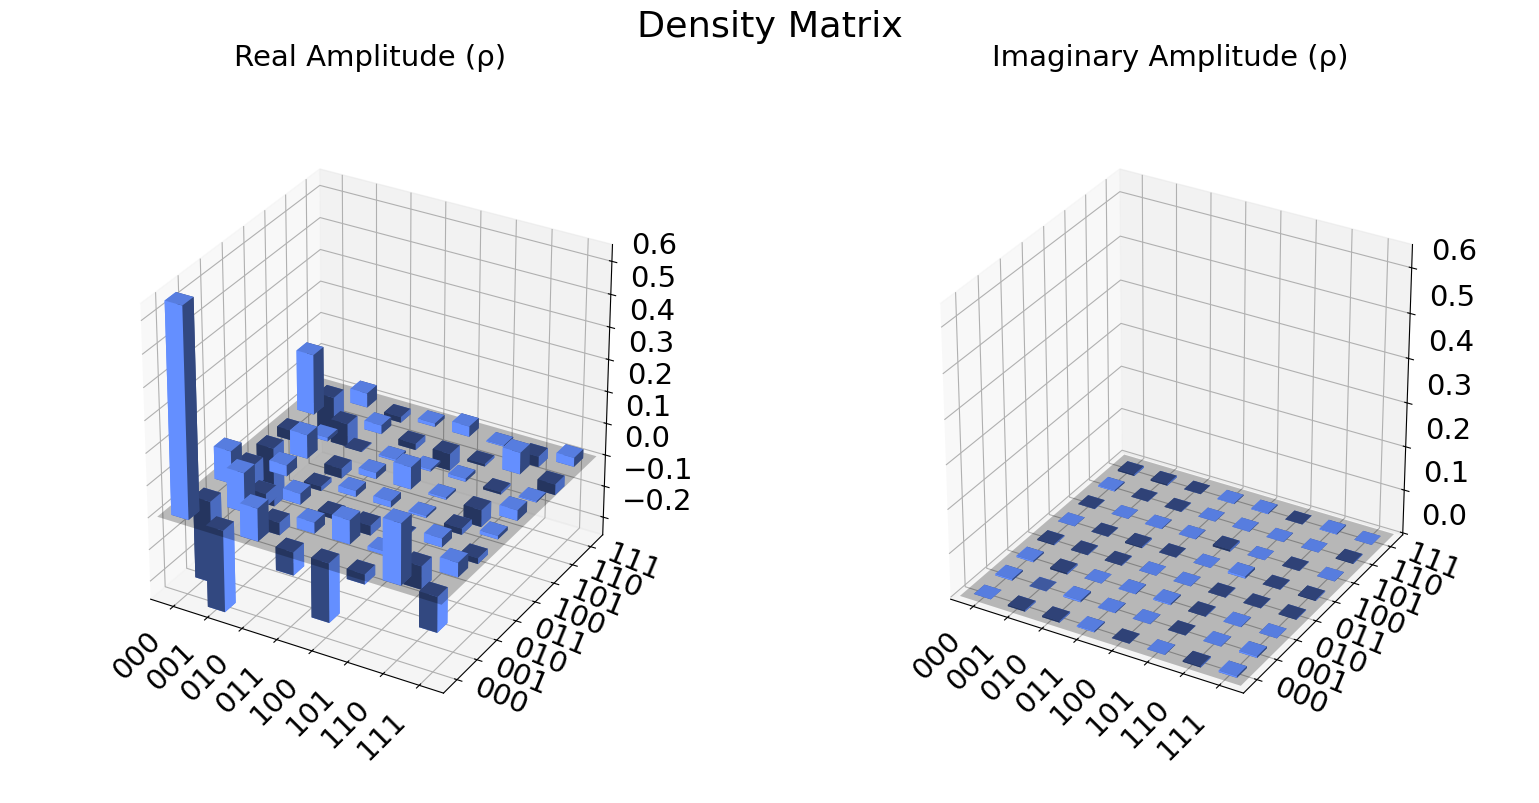

In [7]:
# Visualize the state
from qiskit.visualization import plot_state_city

state = qstdata.analysis_results("state", dataframe=True).iloc[0].value
plot_state_city(state, title='Density Matrix')

### QST with error mitigation

The measurement error mitigation is realized through `mthree` calibrations. Read [here](https://qiskit.github.io/qiskit-addon-mthree/) for more details.

In [8]:
from qiskit_experiments.library import MitigatedStateTomography

# Set number of experiment shots
shots = 10000

# Error Mitigated QST Experiment
mitqstexp = MitigatedStateTomography(ansatz)
mitqstexp.set_run_options(shots=shots)
mitqstdata = mitqstexp.run(backend, seed_simulation=999).block_for_results()

In [9]:
# Fidelity of error mitigated state reconstruction
mit_fid_result = mitqstdata.analysis_results("state_fidelity", dataframe=True).iloc[0]
print("State Fidelity (mitigated) = {:.5f}".format(mit_fid_result.value))
print("State Fidelity (raw) = {:.5f}".format(fid_result.value))

State Fidelity (mitigated) = 0.93165
State Fidelity (raw) = 0.90931


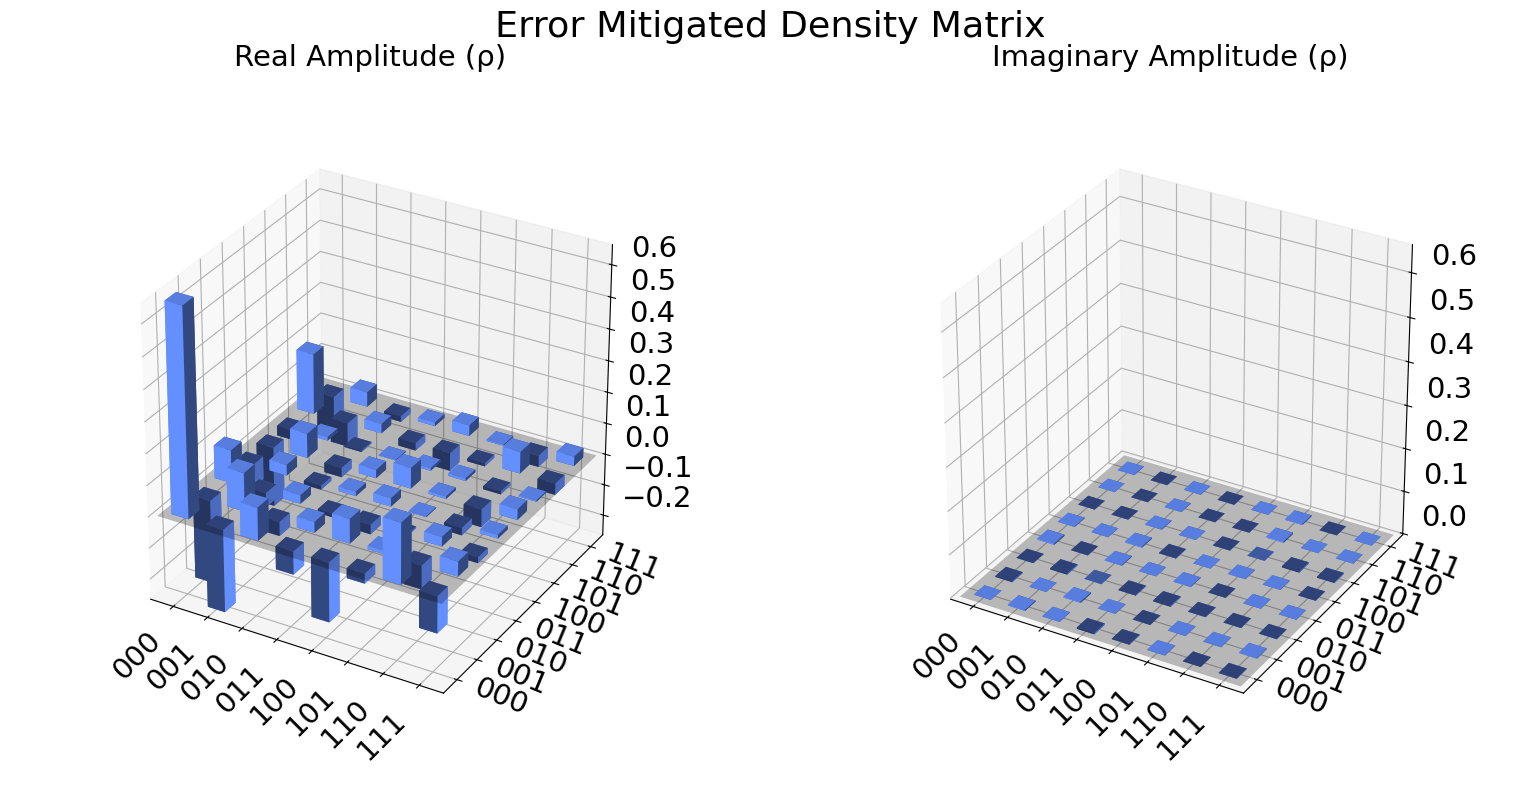

In [10]:
# Visualize the state
from qiskit.visualization import plot_state_city

mit_state = mitqstdata.analysis_results("state", dataframe=True).iloc[0].value
plot_state_city(mit_state, title='Error Mitigated Density Matrix')

### Runtime scaling

**Note:** The following code block might take few minutes.

In [12]:
import time
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm

shots = 10000
num_layers = 4
repetitions = 5

# Collect data [num_qubits, trial, runtime_s, fidelity]
data = []
total_runs = 5 * repetitions

for num_qubits, trial in tqdm(
    product(range(1, 6), range(0, repetitions)),
    total=total_runs,
    desc="QST Runs"
):
    # 1) Build ansatz
    ansatz = real_amplitudes(num_qubits, entanglement='pairwise', reps=num_layers, skip_final_rotation_layer=True)
    params = loaded_param['parameter'][(num_qubits, num_layers)][trial]
    ansatz.assign_parameters(params, inplace=True)

    # 2) Set up the tomography experiment
    qst = StateTomography(ansatz)
    qst.set_run_options(shots=shots)

    # 3) Time the run 
    t0 = time.time()
    expdata = qst.run(backend, seed_simulation=999).block_for_results()
    # expdata = qst.run(noiseless_backend, seed_simulation=999).block_for_results()
    runtime = time.time() - t0

    # 4) Extract the fidelity result
    df = expdata.analysis_results("state_fidelity", dataframe=True)
    fidelity = float(df.iloc[0].value)

    # 5) Record data
    data.append({
        "num_qubits": num_qubits,
        "trial": trial+1,
        "runtime": runtime,
        "fidelity": fidelity
    })

QST Runs: 100%|██████████| 25/25 [02:45<00:00,  6.63s/it]


In [13]:
# Turn into a DataFrame for easy plotting/analysis
results_df = pd.DataFrame(data)
results_df

,num_qubits,trial,runtime,fidelity
0,1,1,4.650336,0.975905
1,1,2,4.418525,0.984209
2,1,3,4.203234,0.987117
3,1,4,4.509222,0.985490
4,1,5,3.275779,0.978084
5,2,1,5.490279,0.936565
6,2,2,4.046259,0.932882
7,2,3,4.131225,0.942823
8,2,4,4.835262,0.935491
9,2,5,3.206249,0.937145


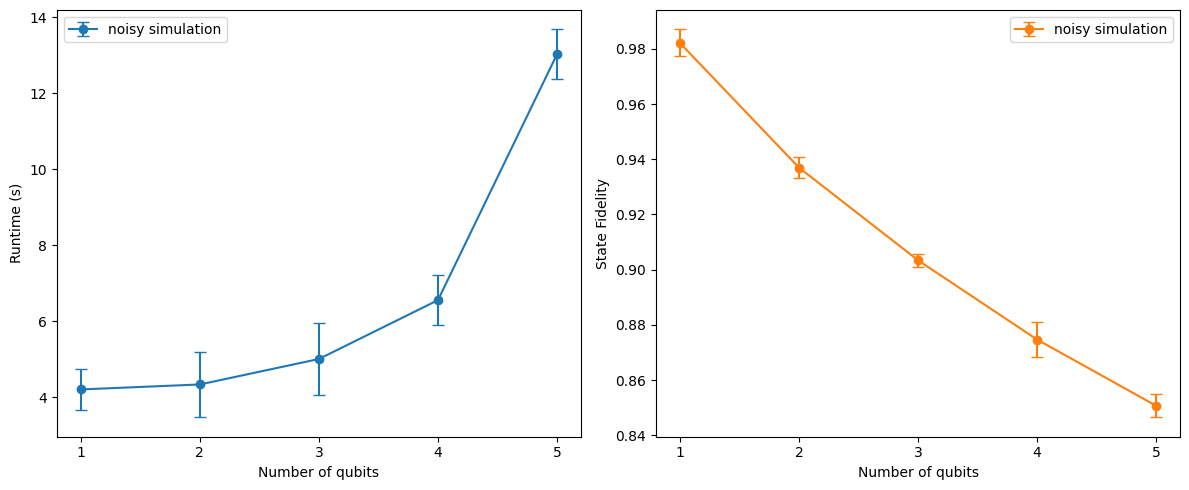

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# 1) Aggregate data by qubit count 
# assume results_df has columns: num_qubits, trial, runtime, fidelity
grp = results_df.groupby('num_qubits').agg(
    runtime_mean=('runtime','mean'),
    runtime_std =('runtime','std'),
    fidelity_mean=('fidelity','mean'),
    fidelity_std =('fidelity','std'),
)
x = grp.index.values            # array([1,2,3,4,5])

rt_mean = grp['runtime_mean'].values
rt_err  = grp['runtime_std'].values
fid_mean = grp['fidelity_mean'].values
fid_err  = grp['fidelity_std'].values

# 2) Fit runtime 
def runtime_model(n, c):
    return c * 3**n

popt_rt, _ = curve_fit(runtime_model, x, rt_mean, p0=[0.1])
rt_fit = runtime_model(x, *popt_rt)

# 3) Fit fidelity to exponential decay A * B**n 
def fidelity_model(n, A, B):
    return A * B**(n)

popt_fid, _ = curve_fit(fidelity_model, x, fid_mean, p0=[1.0, 0.99])
fid_fit = fidelity_model(x, *popt_fid)

# 4) Plot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
xticks = [1,2,3,4,5]
ax1.set_xticks(xticks)
ax2.set_xticks(xticks)

# Runtime subplot
ax1.errorbar(x, rt_mean, yerr=rt_err, fmt='o-', color="tab:blue", capsize=4, label='noisy simulation')
# ax1.plot(x, rt_fit, '-', label=f'fit curve')
ax1.set_xlabel('Number of qubits')
ax1.set_ylabel('Runtime (s)')
ax1.legend()

# Fidelity subplot
ax2.errorbar(x, fid_mean, yerr=fid_err, fmt='o-', color="tab:orange", capsize=4, label='noisy simulation')
# ax2.plot(x, fid_fit, '-', label=f'fit curve')
ax2.set_xlabel('Number of qubits')
ax2.set_ylabel('State Fidelity')
ax2.legend()

plt.tight_layout()
plt.show()

---


## Software info

In [15]:
import qiskit
import qiskit_aer
import qiskit_ibm_runtime
import qiskit_experiments

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit Aer: {qiskit_aer.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print(f'Qiskit Experiments: {qiskit_experiments.__version__}')

Qiskit: 2.1.2
Qiskit Aer: 0.17.1
Qiskit IBM Runtime: 0.41.1
Qiskit Experiments: 0.12.0
